In [76]:
from numba import jit
import numpy as np

In [106]:
def dfs(matrix, visited, i, j, M, N):
    if i < 0 or i >= M or j < 0 or j >= N or matrix[i][j] == 0 or visited[i][j]:
        return
    visited[i][j] = True
    dfs(matrix, visited, i - 1, j, M, N)  # up
    dfs(matrix, visited, i + 1, j, M, N)  # down
    dfs(matrix, visited, i, j - 1, M, N)  # left
    dfs(matrix, visited, i, j + 1, M, N)  # right

@jit(nopython=True)
def jit_stack_dfs(matrix, visited, i, j, M, N):
    """Perform depth-first search to mark connected land cells (1s)."""
    stack = [(i, j)]

    while stack:
        x, y = stack.pop()
        if x < 0 or x >= M or y < 0 or y >= N or matrix[x, y] == 0 or visited[x, y]:
            continue

        visited[x, y] = True

        # Push adjacent cells onto the stack
        stack.append((x - 1, y))  # up
        stack.append((x + 1, y))  # down
        stack.append((x, y - 1))  # left
        stack.append((x, y + 1))  # right

@jit(nopython=True)
def jit_dfs(matrix, visited, i, j, M, N):
    if i < 0 or i >= M or j < 0 or j >= N or matrix[i, j] == 0 or visited[i, j]:
        return
    visited[i][j] = True
    jit_dfs(matrix, visited, i - 1, j, M, N)  # up
    jit_dfs(matrix, visited, i + 1, j, M, N)  # down
    jit_dfs(matrix, visited, i, j - 1, M, N)  # left
    jit_dfs(matrix, visited, i, j + 1, M, N)  # right

In [109]:
def count_islands(matrix, M, N):
    visited = [[False for _ in range(N)] for _ in range(M)]
    island_count = 0
    for i in range(M):
        for j in range(N):
            if matrix[i][j] == 1 and not visited[i][j]:
                dfs(matrix, visited, i, j, M, N)
                island_count += 1
    return island_count

@jit(nopython=True)
def jit_count_islands(matrix, M, N):
    visited = np.full((M, N), False, dtype=np.bool_)  # Efficient boolean array creation
    island_count = 0
    for i in range(M):
        for j in range(N):
            if matrix[i, j] == 1 and not visited[i, j]:
                jit_dfs(matrix, visited, i, j, M, N)
                island_count += 1
    return island_count

@jit(nopython=True)
def jit_stack_count_islands(matrix, M, N):
    visited = np.full((M, N), False, dtype=np.bool_)  # Efficient boolean array creation
    island_count = 0
    for i in range(M):
        for j in range(N):
            if matrix[i, j] == 1 and not visited[i, j]:
                jit_stack_dfs(matrix, visited, i, j, M, N)
                island_count += 1
    return island_count

In [110]:
# Input reading (example usage)
def main():
    # Input number of rows (M) and columns (N)
    M, N = map(int, input().split())
    
    # Input the matrix
    matrix = [list(map(int, input().split())) for _ in range(M)]
    
    # Output the number of islands
    output = count_islands(matrix, M, N)
    print(f'Output: {output}')

In [111]:
import time

def test_dfs(M, N, matrix):
    times = []
    for _ in range(100):
        start_time = time.perf_counter()
        output = count_islands(matrix, M, N)
        times.append(time.perf_counter() - start_time)
    average_time = sum(times)/len(times)
    # print(f'Normal: output: {output}, average time: {average_time} s')
    return average_time

def test_jit_dfs(M, N, matrix):
    times = []
    for _ in range(100):
        start_time = time.perf_counter()
        np_matrix = np.array(matrix)
        output = jit_count_islands(np_matrix, M, N)
        times.append(time.perf_counter() - start_time)
    average_time = sum(times)/len(times)
    # print(f'Normal: output: {output}, average time: {average_time} s')
    return average_time

def test_jit_stack_dfs(M, N, matrix):
    times = []
    for _ in range(100):
        start_time = time.perf_counter()
        np_matrix = np.array(matrix)
        output = jit_stack_count_islands(np_matrix, M, N)
        times.append(time.perf_counter() - start_time)
    average_time = sum(times)/len(times)
    # print(f'Normal: output: {output}, average time: {average_time} s')
    return average_time

In [86]:
import random

def generate_large_matrix(M, N, density=0.3):
    matrix = []
    for i in range(M):
        row = [1 if random.random() < density else 0 for _ in range(N)]
        matrix.append(row)
    matrix = np.array(matrix)
    return matrix

# Generate a 1000x1000 matrix with 30% land (1s)
M = 1000
N = 500
matrix = generate_large_matrix(M, N, density=0.3)

In [97]:
from tqdm import trange

proportion_of_times = []
for M in trange(10, 500, 10):
    N = M
    matrix = generate_large_matrix(M, N, density=0.3)
    average_jit_time = test_jit_dfs(M, N, matrix)
    average_time = test_dfs(M, N, matrix)
    proportion_of_times.append(average_time/average_jit_time)

100%|██████████| 49/49 [03:54<00:00,  4.78s/it]


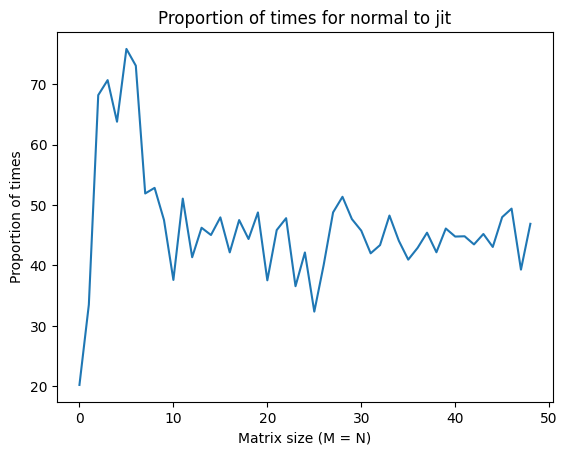

In [98]:
import matplotlib.pyplot as plt

plt.plot(proportion_of_times)
plt.xlabel('Matrix size (M = N)')
plt.ylabel('Proportion of times')
plt.title('Proportion of times for normal to jit')
plt.show()

In [112]:
from tqdm import trange

proportion_of_times = []
for M in trange(10, 500, 10):
    N = M
    matrix = generate_large_matrix(M, N, density=0.3)
    average_jit_time = test_jit_dfs(M, N, matrix)
    average_jit_stack_time = test_jit_stack_dfs(M, N, matrix)
    proportion_of_times.append(average_jit_stack_time/average_jit_time)

100%|██████████| 49/49 [00:21<00:00,  2.26it/s]


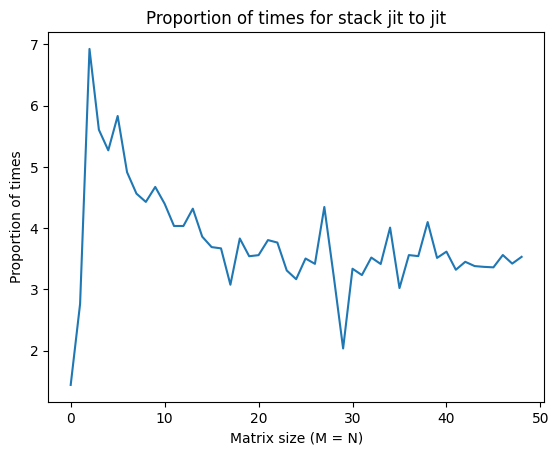

In [113]:
import matplotlib.pyplot as plt

plt.plot(proportion_of_times)
plt.xlabel('Matrix size (M = N)')
plt.ylabel('Proportion of times')
plt.title('Proportion of times for stack jit to jit')
plt.show()